# Generic Conditional Laws for Random-Fields - via:

## Universal $\mathcal{P}_1(\mathbb{R})$-Deep Neural Model $\mathcal{NN}_{1_{\mathbb{R}^n},\mathcal{D}}^{\sigma:\star}$.

---

By: [Anastasis Kratsios](https://people.math.ethz.ch/~kratsioa/) - 2021.

---

## What does this code do?
Described in GUI file...

#### Mode:
Software/Hardware Testing or Real-Deal?

In [191]:
# trial_run = True

### Simulation Method:

In [194]:
# # Random DNN
# f_unknown_mode = "Heteroskedastic_NonLinear_Regression"

# # Random DNN internal noise
# # f_unknown_mode = "DNN_with_Random_Weights"
# Depth_Bayesian_DNN = 2
# width = 20

# # Random Dropout applied to trained DNN
# # f_unknown_mode = "DNN_with_Bayesian_Dropout"
# Dropout_rate = 0.1

# # Rough SDE (time 1)
# # f_unknown_mode = "Rough_SDE"

# GD with Randomized Input
# f_unknown_mode = "GD_with_randomized_input"
# GD_epochs = 2

#### Rough SDE Meta-Parameters

In [196]:
# # SDE with Rough Driver
# N_Euler_Steps = 10**1
# Hurst_Exponent = 0.01

# def alpha(t,x):
#     output_drift_update = t-x
#     return output_drift_update

# def beta(t,x):
#     output_vol_update = (t+0.001)*np.diag(np.cos(x))
#     return output_vol_update

---
# Training Algorithm:
---
- Random $\delta$-bounded partition on input space,
- Train deep classifier on infered classes.
---
---
---
## Notes - Why the procedure is so computationally efficient?
---
 - The sample barycenters do not require us to solve for any new Wasserstein-1 Barycenters; which is much more computationally costly,
 - Our training procedure never back-propages through $\mathcal{W}_1$ since steps 2 and 3 are full-decoupled.  Therefore, training our deep classifier is (comparatively) cheap since it takes values in the standard $N$-simplex.

---

## Load Auxiliaries

In [198]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Architecture Builder
exec(open('Benchmarks_Model_Builder.py').read())
# Import time separately
import time
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'


# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"


### Set Seed
random.seed(2021)
np.random.seed(2021)
tf.random.set_seed(2021)

Deep Feature Builder - Ready
Deep Classifier - Ready
Deep Feature Builder - Ready


## Meta-Parameters

### Simulation

## Problem Dimension

In [201]:
# problem_dim = 3

#### Grid Hyperparameter(s)
- Ratio $\frac{\text{Testing Datasize}}{\text{Training Datasize}}$.
- Number of Training Points to Generate

In [203]:
# train_test_ratio = .2
# N_train_size = 10**2

Monte-Carlo Paramters

In [205]:
# ## Monte-Carlo
# N_Monte_Carlo_Samples = 10**2

Initial radis of $\delta$-bounded random partition of $\mathcal{X}$!

In [207]:
# # Hyper-parameters of Cover
# delta = 0.01
# Proportion_per_cluster = .5

**Note**: Setting *N_Quantizers_to_parameterize* prevents any barycenters and sub-sampling.

## Initialize Data

In [208]:
N_test_size = int(np.round(N_train_size*train_test_ratio,0))

### Initialize Training Data (Inputs)

Try initial sampling-type implementation!  It worked nicely..i.e.: centers were given!

In [209]:
# Get Training Set
X_train = np.random.uniform(size=np.array([N_train_size,problem_dim]),low=.5,high=1.5)

# Get Testing Set
test_set_indices = np.random.choice(range(X_train.shape[0]),N_test_size)
X_test = X_train[test_set_indices,]
X_test = X_test + np.random.uniform(low=-(delta/np.sqrt(problem_dim)), 
                                    high = -(delta/np.sqrt(problem_dim)),
                                    size = X_test.shape)

# Simulate from: $Y=f(X,W)$ 
- Random DNN (internal noise): 
    - $f(X,W) = f_{\text{unknown}}(X+U)$
- Random DNN: 
    - $f(X,W) = f_{\text{unknown}}(X)+W$
    
*Non-linear dependance on exhaugenous noise.*

## Heteroskedastic Regression Problem

In [210]:
if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
    #-----------#
    # Build DNN #
    #-----------#
    W_feature = np.random.uniform(size=np.array([width,problem_dim]),low=-.5,high=.5)
    W_readout = np.random.uniform(size=np.array([1,width]),low=-.5,high=.5)
    # Generate Matrices
    for i_weights in range(Depth_Bayesian_DNN):
        W_hidden_loop = np.random.uniform(size=np.array([width,width]),low=-.5,high=.5)
        if i_weights == 0:
            W_hidden_list = [W_hidden_loop]
        else:
            W_hidden_list.append(W_hidden_loop)
    # Define DNN Applier
    def f_unknown(x):
        x_internal = x.reshape(-1,)
        x_internal = np.matmul(W_feature,x)
        #Deep Layer(s)
        for i in range(Depth_Bayesian_DNN):
            W_internal = W_hidden_list[i]
            x_internal = np.matmul(W_internal,x_internal)
            x_internal = np.maximum(0,x_internal)    
        # Readout Layer
        x_internal = np.matmul(W_readout,x_internal)
        return x_internal

    # Define Simulator
    def Simulator(x_in):
        var = np.sqrt(np.sum(x_in**2))
        # Pushforward
        f_x = f_unknown(x_in)
        # Apply Noise After
        noise = np.random.laplace(0,var,N_Monte_Carlo_Samples)
        f_x_noise = np.cos(f_x) + noise
        return f_x_noise

## Bayesian DNN

In [211]:
if f_unknown_mode == "DNN_with_Random_Weights":
    def f_unknown(x):
        x_internal = x.reshape(-1,) 
        # Feature Map Layer
        W_feature = np.random.uniform(size=np.array([width,problem_dim]),low=-.5,high=.5)
        x_internal = np.matmul(W_feature,x)
    #     Deep Layer(s)
        for i in range(Depth_Bayesian_DNN):
            W_internal = np.random.uniform(size=np.array([width,width]),low=-.5,high=.5)
            x_internal = np.matmul(W_internal,x_internal)
            x_internal = np.maximum(0,x_internal)    
        # Readout Layer
        W_readout = np.random.uniform(size=np.array([1,width]),low=-.5,high=.5)
        x_internal = np.matmul(W_readout,x_internal)
        return x_internal


    def Simulator(x_in):
        for i_MC in range(N_Monte_Carlo_Samples):
            y_MC_loop = f_unknown(x_in)
            if i_MC == 0:
                y_MC = y_MC_loop
            else:
                y_MC = np.append(y_MC,y_MC_loop)
        return y_MC

## Bayesian Dropout

In [212]:
if f_unknown_mode == "DNN_with_Bayesian_Dropout":
    # Initialize Drouput Parameters
    N_Dropout = int(np.maximum(1,round(width*Dropout_rate)))
    
    #-----------#
    # Build DNN #
    #-----------#
    W_feature = np.random.uniform(size=np.array([width,problem_dim]),low=-.5,high=.5)
    W_readout = np.random.uniform(size=np.array([1,width]),low=-.5,high=.5)
    # Generate Matrices
    for i_weights in range(Depth_Bayesian_DNN):
        W_hidden_loop = np.random.uniform(size=np.array([width,width]),low=-.5,high=.5)
        if i_weights == 0:
            W_hidden_list = [W_hidden_loop]
        else:
            W_hidden_list.append(W_hidden_loop)
    # Define DNN Applier
    def f_unknown(x):
        x_internal = x.reshape(-1,)
        x_internal = np.matmul(W_feature,x)
        #Deep Layer(s)
        for i in range(Depth_Bayesian_DNN):
            W_internal = W_hidden_list[i]
            # Apply Random Dropout
            random_mask_coordinates_i = np.random.choice(range(width),N_Dropout)
            random_mask_coordinates_j = np.random.choice(range(width),N_Dropout)
            W_internal[random_mask_coordinates_i,random_mask_coordinates_j] = 0
            # Apply Dropped-out layer
            x_internal = np.matmul(W_internal,x_internal)
            x_internal = np.maximum(0,x_internal)    
        # Readout Layer
        x_internal = np.matmul(W_readout,x_internal)
        return x_internal

    def Simulator(x_in):
        for i_MC in range(N_Monte_Carlo_Samples):
            y_MC_loop = f_unknown(x_in)
            if i_MC == 0:
                y_MC = y_MC_loop
            else:
                y_MC = np.append(y_MC,y_MC_loop)
        return y_MC

### fSDEs
Lean the conditional law of $I_{X_1 \in Ball(0,1)}$ where $X_t$ solves an SDE with fBM driver.

In [213]:
if f_unknown_mode == "Rough_SDE":
    #-------------------#
    # Build DNN (Drift) #
    #-------------------#
    W_feature = np.random.uniform(size=np.array([width,problem_dim]),low=-.5,high=.5)
    W_readout = np.random.uniform(size=np.array([problem_dim,width]),low=-.5,high=.5)
    # Generate Matrices
    for i_weights in range(Depth_Bayesian_DNN):
        W_hidden_loop = np.random.uniform(size=np.array([width,width]),low=-.5,high=.5)
        if i_weights == 0:
            W_hidden_list = [W_hidden_loop]
        else:
            W_hidden_list.append(W_hidden_loop)
    # Define DNN Applier
    def f_unknown_drift(x):
        x_internal = x.reshape(-1,)
        x_internal = np.matmul(W_feature,x)
        #Deep Layer(s)
        for i in range(Depth_Bayesian_DNN):
            W_internal = W_hidden_list[i]
            x_internal = np.matmul(W_internal,x_internal)
            x_internal = np.maximum(0,x_internal)    
        # Readout Layer
        x_internal = np.matmul(W_readout,x_internal)
        return x_internal
    
    #-----------------#
    # Build DNN (Vol) #
    #-----------------#
    W_feature_vol = np.random.uniform(size=np.array([width,problem_dim]),low=-.5,high=.5)
    W_readout_vol = np.random.uniform(size=np.array([problem_dim,width]),low=-.5,high=.5)
    # Generate Matrices
    for i_weights in range(Depth_Bayesian_DNN):
        W_hidden_loop_vol = np.random.uniform(size=np.array([width,width]),low=-.5,high=.5)
        if i_weights == 0:
            W_hidden_list_vol = [W_hidden_loop_vol]
        else:
            W_hidden_list_vol.append(W_hidden_loop_vol)
    def f_unknown_vol(x):
        x_internal = x.reshape(-1,)
        x_internal = np.matmul(W_feature,x)
        #Deep Layer(s)
        for i in range(Depth_Bayesian_DNN):
            W_internal = W_hidden_list[i]
            x_internal = np.matmul(W_internal,x_internal)
            x_internal = np.maximum(0,x_internal)    
        # Readout Layer
        x_internal = np.matmul(W_readout,x_internal)
        x_internal = np.outer(x_internal,x_internal)
        x_internal = np.tanh(x_internal)
        return x_internal
    
    
    
    # Define DNN Applier
    def f_unknown(x):
        x_internal = x.reshape(-1,)
        # Random Radius
#         rand_radius = np.random.exponential(1)
#         left_random_ball_Q = 0
        exit_time = 0
        # Get fBM path
        for d in range(problem_dim):
            fBM_gen_loop = (((FBM(n=N_Euler_Steps, hurst=Hurst_Exponent, length=1, method='daviesharte')).fbm())[1:]).reshape(-1,1)
            if d == 0:
                fBM_gen = fBM_gen_loop
            else:
                fBM_gen = np.append(fBM_gen,fBM_gen_loop,axis=-1)
        # Perform Integral
        for t in range(N_Euler_Steps):
            drift_update = f_unknown_drift(x_internal)/N_Euler_Steps
            vol_update = f_unknown_vol(x_internal)
            x_internal = x_internal + drift_update + np.matmul(vol_update,fBM_gen[t,])
            
            # Test if the process has left the ball
            #left_random_ball_Q = max(left_random_ball_Q,(np.sqrt(np.sum((x_internal - x.reshape(-1,))**2)) <= rand_radius)*1)        
            if np.sqrt(np.sum((x_internal - x.reshape(-1,))**2)) <= 1:
                exit_time = t/N_Euler_Steps
            else:
                break
        return exit_time

    def Simulator(x_in):
        for i_MC in range(N_Monte_Carlo_Samples):
            y_MC_loop = f_unknown(x_in)
            if i_MC == 0:
                y_MC = y_MC_loop
            else:
                y_MC = np.append(y_MC,y_MC_loop)
        return y_MC

### Gradient Descent with random initialization:
$$
Y_x\triangleq \hat{f}_{\theta_T}(x),\qquad \theta_{t+1} \triangleq \theta_t - \nabla \sum_{x\in \mathbb{X}} \|\hat{f}_{\theta_t}(x)-f(x)\|, \qquad \theta_0 \sim N_d(0,1).
$$

#================================================#
 Training Datasize: 170 and test datasize: 42.  
#================================================#


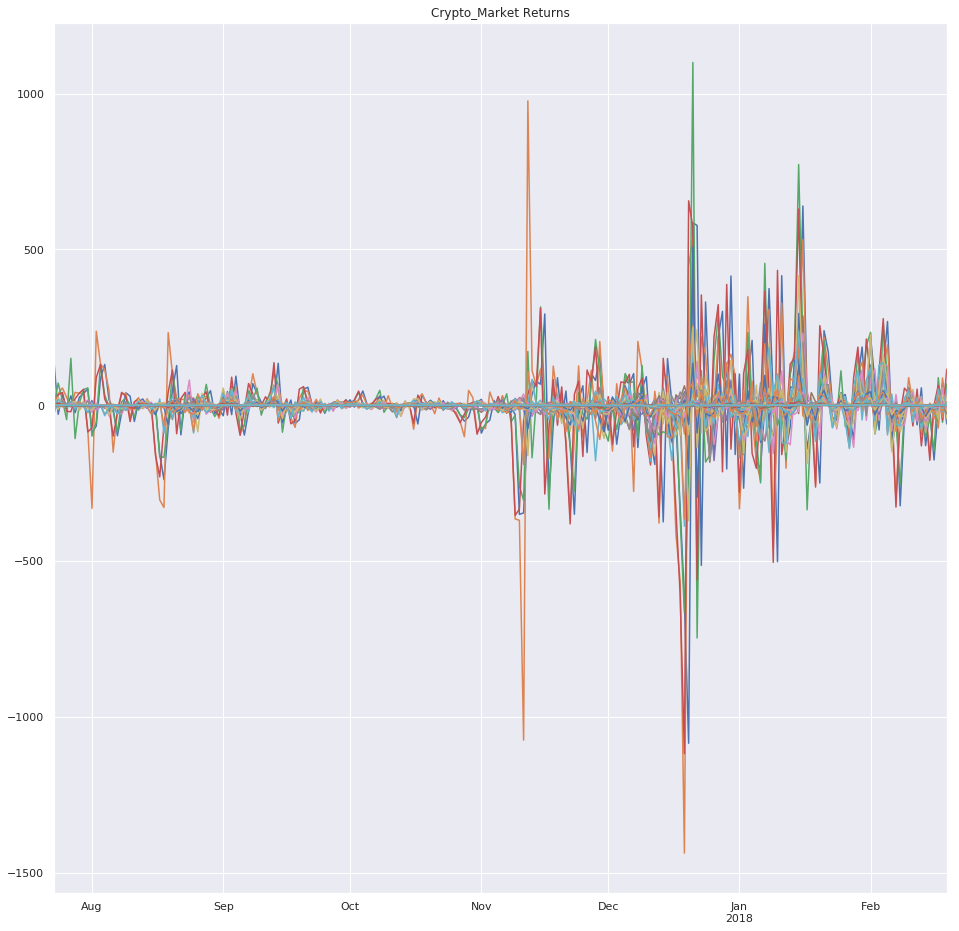

In [214]:
if f_unknown_mode == "GD_with_randomized_input":
    # Auxiliary Initialization(s)
    Train_step_proportion = 1-train_test_ratio

    #--------------#
    # Prepare Data #
    #--------------#
    # Read Dataset
    crypto_data = pd.read_csv('inputs/data/cryptocurrencies/Cryptos_All_in_one.csv')
    # Format Date-Time
    crypto_data['Date'] = pd.to_datetime(crypto_data['Date'],infer_datetime_format=True)
    crypto_data.set_index('Date', drop=True, inplace=True)
    crypto_data.index.names = [None]

    # Remove Missing Data
    crypto_data = crypto_data[crypto_data.isna().any(axis=1)==False]

    # Get Returns
    crypto_returns = crypto_data.diff().iloc[1:]

    # Parse Regressors from Targets
    ## Get Regression Targets
    crypto_target_data = pd.DataFrame({'BITCOIN-closing':crypto_returns['BITCOIN-Close']})
    ## Get Regressors
    crypto_data_returns = crypto_returns.drop('BITCOIN-Close', axis=1)  

    #-------------#
    # Subset Data #
    #-------------#
    # Get indices
    N_train_step = int(round(crypto_data_returns.shape[0]*Train_step_proportion,0))
    N_test_set = int(crypto_data_returns.shape[0] - round(crypto_data_returns.shape[0]*Train_step_proportion,0))
    # # Get Datasets
    X_train = crypto_data_returns[:N_train_step]
    X_test = crypto_data_returns[-N_test_set:]

    ## Coerce into format used in benchmark model(s)
    data_x = X_train
    data_x_test = X_test
    # Get Targets 
    data_y = crypto_target_data[:N_train_step]
    data_y_test = crypto_target_data[-N_test_set:]

    # Scale Data
    scaler = StandardScaler()
    data_x = scaler.fit_transform(data_x)
    data_x_test = scaler.transform(data_x_test)

    # # Update User
    print('#================================================#')
    print(' Training Datasize: '+str(X_train.shape[0])+' and test datasize: ' + str(X_test.shape[0]) + '.  ')
    print('#================================================#')

    # # Set First Run to Off
    First_run = False

    #-----------#
    # Plot Data #
    #-----------#
    fig = crypto_data_returns.plot(figsize=(16, 16))
    fig.get_legend().remove()
    plt.title("Crypto_Market Returns")

    # SAVE Figure to .eps
    plt.savefig('./outputs/plots/Crypto_Data_returns.pdf', format='pdf')

    # Redefine Meta-Parameters #
    #--------------------------#
    # Redefine Training Set inputs and ys to train DNN:
    data_y_to_train_DNN_on = (data_y.to_numpy()).reshape(-1,)
    X_train = data_x
    X_test = data_x_test
    problem_dim=data_x.shape[1]



    # Initialize Target Function #
    #----------------------------#
    # Initialize DNN to train
    f_model = get_ffNN(width, Depth_Bayesian_DNN, 0.001, problem_dim, 1)

    # Define Stochastic Prediction Function:
    def f_unknown():
        f_model.fit(data_x,data_y_to_train_DNN_on,epochs = GD_epochs)
        f_x_trained_with_random_initialization_x_train = f_model.predict(X_train)
        f_x_trained_with_random_initialization_x_test = f_model.predict(X_test)
        return f_x_trained_with_random_initialization_x_train, f_x_trained_with_random_initialization_x_test

    def Simulator(x_in):
        for i_MC in range(N_Monte_Carlo_Samples):
            y_MC_loop = f_unknown(x_in)
            if i_MC == 0:
                y_MC = y_MC_loop
            else:
                y_MC = np.append(y_MC,y_MC_loop)
        return y_MC

### Initialize Training Data (Outputs)

#### Get Training Set

In [215]:
if f_unknown_mode != "GD_with_randomized_input":
    for i in tqdm(range(X_train.shape[0])):
        # Put Datum
        x_loop = X_train[i,]
        # Product Monte-Carlo Sample for Input
        y_loop = (Simulator(x_loop)).reshape(1,-1)

        # Update Dataset
        if i == 0:
            Y_train = y_loop
            Y_train_mean_emp = np.mean(y_loop)
    #         Y_train_var_emp = np.mean((y_loop - np.mean(y_loop))**2)
        else:
            Y_train = np.append(Y_train,y_loop,axis=0)
            Y_train_mean_emp = np.append(Y_train_mean_emp,np.mean(y_loop))
    #         Y_train_var_emp = np.append(Y_train_var_emp,np.mean((y_loop - np.mean(y_loop))**2))
    # Join mean and Variance Training Data
    # Y_train_var_emp = np.append(Y_train_mean_emp.reshape(-1,1),Y_train_var_emp.reshape(-1,1),axis=1)

#### Get Test Set

In [216]:
if f_unknown_mode != "GD_with_randomized_input":
    # Start Timer
    Test_Set_PredictionTime_MC = time.time()

    # Generate Data
    for i in tqdm(range(X_test.shape[0])):
        # Put Datum
        x_loop = X_test[i,]
        # Product Monte-Carlo Sample for Input
        y_loop = (Simulator(x_loop)).reshape(1,-1)

        # Update Dataset
        if i == 0:
            Y_test = y_loop
        else:
            Y_test = np.append(Y_test,y_loop,axis=0)

    # End Timer
    Test_Set_PredictionTime_MC = time.time() - Test_Set_PredictionTime_MC

#### Do it differently for *"GD_with_randomized_input"* Example.
This variant is more efficient in the case of the gradient-descent with randomized initializations

In [217]:
# This implemention of the GD algorithm is more efficient (but this only holds for the GD Monte-Carlo method):
if f_unknown_mode == "GD_with_randomized_input":
    # Start Timer
    Test_Set_PredictionTime_MC = time.time()
    for j_MC in range(N_Monte_Carlo_Samples):
        # MC of SGD
        Y_train_loop,Y_test_loop = f_unknown()
        # Update Dataset
        if j_MC == 0:
            Y_train = Y_train_loop
            Y_test = Y_test_loop
        else:
            Y_train = np.append(Y_train,Y_train_loop,axis=1)
            Y_test = np.append(Y_test,Y_test_loop,axis=1)
    # End Timer
    Test_Set_PredictionTime_MC = time.time() - Test_Set_PredictionTime_MC
    
## Get means for mean-prediction models
    ## Training
    for i in tqdm(range(X_train.shape[0])):
        # Product Monte-Carlo Sample for Input
        y_loop = Y_train[i,]

        # Update Dataset
        if i == 0:
            Y_train_mean_emp = np.mean(y_loop)
        else:
            Y_train_mean_emp = np.append(Y_train_mean_emp,np.mean(y_loop))
    ## Testing
    ### Continue Timer
    Test_Set_PredictionTime_MC2 = time.time()
    for i in tqdm(range(X_test.shape[0])):
        # Product Monte-Carlo Sample for Input
        y_loop_test = Y_test[i,]

        # Update Dataset
        if i == 0:
            Y_test_mean_emp = np.mean(y_loop_test)
        else:
            Y_test_mean_emp = np.append(Y_test_mean_emp,np.mean(y_loop_test))
    
    # End Timer
    Test_Set_PredictionTime_MC = (time.time() - Test_Set_PredictionTime_MC2) + Test_Set_PredictionTime_MC

Epoch 1/2
6/6 [==============================] - 0s 2ms/step - loss: 474.7013 - mse: 528283.7500 - mae: 474.7013 - mape: 100.0995
Epoch 2/2
6/6 [==============================] - 0s 2ms/step - loss: 474.6953 - mse: 528272.5000 - mae: 474.6953 - mape: 100.1070
Epoch 1/2
6/6 [==============================] - 0s 1ms/step - loss: 474.6870 - mse: 528255.1250 - mae: 474.6870 - mape: 100.1164
Epoch 2/2
6/6 [==============================] - 0s 2ms/step - loss: 474.6761 - mse: 528232.1250 - mae: 474.6761 - mape: 100.1212
Epoch 1/2
6/6 [==============================] - 0s 2ms/step - loss: 474.6578 - mse: 528191.8750 - mae: 474.6578 - mape: 100.1277
Epoch 2/2
6/6 [==============================] - 0s 3ms/step - loss: 474.6332 - mse: 528139.0625 - mae: 474.6332 - mape: 100.1256
Epoch 1/2
6/6 [==============================] - 0s 1ms/step - loss: 474.5929 - mse: 528050.6250 - mae: 474.5929 - mape: 100.1235
Epoch 2/2
6/6 [==============================] - 0s 1ms/step - loss: 474.5414 - mse: 52794

6/6 [==============================] - 0s 1ms/step - loss: 312.4649 - mse: 294280.8750 - mae: 312.4649 - mape: 298.0443
Epoch 2/2
6/6 [==============================] - 0s 2ms/step - loss: 311.9660 - mse: 293764.0938 - mae: 311.9660 - mape: 297.7556
Epoch 1/2
6/6 [==============================] - 0s 1ms/step - loss: 311.3821 - mse: 293074.0625 - mae: 311.3821 - mape: 297.3880
Epoch 2/2
6/6 [==============================] - 0s 2ms/step - loss: 310.8503 - mse: 292470.5312 - mae: 310.8503 - mape: 298.0609
Epoch 1/2
6/6 [==============================] - 0s 2ms/step - loss: 310.2288 - mse: 291554.7188 - mae: 310.2288 - mape: 299.9199
Epoch 2/2
6/6 [==============================] - 0s 2ms/step - loss: 309.7458 - mse: 291017.3125 - mae: 309.7458 - mape: 299.6715
Epoch 1/2
6/6 [==============================] - 0s 1ms/step - loss: 309.0920 - mse: 290231.3750 - mae: 309.0920 - mape: 299.9898
Epoch 2/2
6/6 [==============================] - 0s 1ms/step - loss: 308.5600 - mse: 289568.5000 - m

### Get the measures $\hat{\mu}_n$ via Barycenters...*aka "K-Means"*!
- We first identify N-balls in the input space (which is equivalent to identifying N balls in the output space by uniform continuity)
- We then project each of the centers of these balls onto the nearest element of the training set.
- The corresponing (observed) $f(x)\in \mathcal{P}_1(\mathbb{R})$ are our $\hat{\mu}_n$ (for $n=1,\dots,N$).


**NB:** *This is essentially what is done in the proof, exect there, we have access to the correct N and the optimal balls (outside the training dataset)...which we clearly do not here...*

In [218]:
# Initialize k_means
N_Quantizers_to_parameterize = int(np.maximum(2,round(Proportion_per_cluster*X_train.shape[0])))
kmeans = KMeans(n_clusters=N_Quantizers_to_parameterize, random_state=0).fit(X_train)
# Get Classes
Train_classes = np.array(pd.get_dummies(kmeans.labels_))
# Get Center Measures
Barycenters_Array_x = kmeans.cluster_centers_

In [255]:
for i in tqdm(range(Barycenters_Array_x.shape[0])):
    # Identify Nearest Datapoint to a ith Barycenter
    #------------------------------------------------------------------------------------------------------#
    ## Get Barycenter "out of sample" in X (NB there is no data-leakage since we know nothing about Y!)
    Bar_x_loop = Barycenters_Array_x[i,]
    ## Project Barycenter onto testset
    distances = np.sum(np.abs(X_train-Bar_x_loop.reshape(-1,)),axis=1)
    Bar_x_loop = X_train[np.argmin(distances),]
    #------------------------------------------------------------------------------------------------------#

    # Product Monte-Carlo Sample for Input
    Bar_y_loop = (np.array(Y_train[np.argmin(distances),],dtype=float)).reshape(-1,1)

    # Update Dataset
    if i == 0:
        Barycenters_Array = Bar_y_loop
    else:
        Barycenters_Array = np.append(Barycenters_Array,Bar_y_loop,axis=1)

100%|██████████| 85/85 [00:00<00:00, 11367.40it/s]


# Train Model

#### Start Timer

In [256]:
# Start Timer
Type_A_timer_Begin = time.time()

### Train Deep Classifier

In this step, we train a deep (feed-forward) classifier:
$$
\hat{f}\triangleq \operatorname{Softmax}_N\circ W_J\circ \sigma \bullet \dots \sigma \bullet W_1,
$$
to identify which barycenter we are closest to.

#### Train Deep Classifier

Re-Load Packages and CV Grid

In [257]:
# Re-Load Hyper-parameter Grid
exec(open('CV_Grid.py').read())
# Re-Load Classifier Function(s)
exec(open('Helper_Functions.py').read())

Deep Feature Builder - Ready
Deep Classifier - Ready


Train Deep Classifier

In [258]:
print("==========================================")
print("Training Classifer Portion of Type-A Model")
print("==========================================")

# Redefine (Dimension-related) Elements of Grid
param_grid_Deep_Classifier['input_dim'] = [problem_dim]
param_grid_Deep_Classifier['output_dim'] = [N_Quantizers_to_parameterize]

# Train simple deep classifier
predicted_classes_train, predicted_classes_test, N_params_deep_classifier, timer_output = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter = n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train, 
                                                                                                        y_train = Train_classes,
                                                                                                        X_test = X_test)

print("===============================================")
print("Training Classifer Portion of Type Model: Done!")
print("===============================================")

Training Classifer Portion of Type-A Model
Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   2 out of   2 | elapsed:    3.8s finished


Epoch 1/50
6/6 [==============================] - 0s 1ms/step - loss: 4.5668 - accuracy: 0.0059
Epoch 2/50
6/6 [==============================] - 0s 1ms/step - loss: 4.4713 - accuracy: 0.0059
Epoch 3/50
6/6 [==============================] - 0s 3ms/step - loss: 4.4009 - accuracy: 0.0059
Epoch 4/50
6/6 [==============================] - 0s 3ms/step - loss: 4.3376 - accuracy: 0.0765
Epoch 5/50
6/6 [==============================] - 0s 3ms/step - loss: 4.2806 - accuracy: 0.1824
Epoch 6/50
6/6 [==============================] - 0s 2ms/step - loss: 4.2399 - accuracy: 0.1824
Epoch 7/50
6/6 [==============================] - 0s 2ms/step - loss: 4.1987 - accuracy: 0.1824
Epoch 8/50
6/6 [==============================] - 0s 2ms/step - loss: 4.1577 - accuracy: 0.1824
Epoch 9/50
6/6 [==============================] - 0s 3ms/step - loss: 4.1126 - accuracy: 0.1824
Epoch 10/50
6/6 [==============================] - 0s 1ms/step - loss: 4.0630 - accuracy: 0.1824
Epoch 11/50
6/6 [======================

#### Get Predicted Quantized Distributions
- Each *row* of "Predicted_Weights" is the $\beta\in \Delta_N$.
- Each *Column* of "Barycenters_Array" denotes the $x_1,\dots,x_N$ making up the points of the corresponding empirical measures.

In [268]:
# Initialize Empirical Weights
empirical_weights = (np.ones(N_Monte_Carlo_Samples)/N_Monte_Carlo_Samples).reshape(-1,)

for i in range(Barycenters_Array.shape[0]):
    if i == 0:
        points_of_mass = Barycenters_Array[i,]
    else:
        points_of_mass = np.append(points_of_mass,Barycenters_Array[i,])

In [269]:
if f_unknown_mode != "GD_with_randomized_input":
    # Get Noisless Mean
    direct_facts = np.apply_along_axis(f_unknown, 1, X_train)
    direct_facts_test = np.apply_along_axis(f_unknown, 1, X_test)

#### Get Error(s)

In [270]:
# %run Evaluation.ipynb
exec(open('Evaluation.py').read())

#### Compute *Training* Error(s)

In [271]:
print("#--------------------#")
print(" Get Training Error(s)")
print("#--------------------#")
for i in tqdm(range((X_train.shape[0]))):
    for j in range(N_Quantizers_to_parameterize):
        b_loop = np.repeat(predicted_classes_train[i,j],N_Monte_Carlo_Samples)
        if j == 0:
            b = b_loop
        else:
            b = np.append(b,b_loop)
        b = b.reshape(-1,1)
        b = b
    b = np.array(b,dtype=float).reshape(-1,)
    b = b/N_Monte_Carlo_Samples
    
    # Compute Error(s)
    ## W1
    W1_loop = ot.emd2_1d(points_of_mass,
                         np.array(Y_train[i,]).reshape(-1,),
                         b,
                         empirical_weights)
    
    ## M1
    Mu_hat = np.sum(b*(points_of_mass))
    Mu_MC = np.mean(np.array(Y_train[i,]))
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Mu = direct_facts[i,]
    else:
        Mu = Mu_MC
        
    ### Error(s)
    Mean_loop = (Mu_hat-Mu)
    Mean_loop_MC = (Mu_hat-Mu_MC)
    
    ## Variance
    Var_hat = np.sum(((points_of_mass-Mu_hat)**2)*b)
    Var_MC = np.mean(np.array(Y_train[i]-Mu_MC)**2)
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Var = 2*np.sum(X_train[i,]**2)
    else:
        Var = Var_MC     
    ### Error(s)
    Var_loop = np.abs(Var_hat-Var)
    Var_loop_MC = np.abs(Var_MC-Var)
        
    # Skewness
    Skewness_hat = np.sum((((points_of_mass-Mu_hat)/Var_hat)**3)*b)
    Skewness_MC = np.mean((np.array(Y_train[i]-Mu_MC)/Var_MC)**3)
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Skewness = 0
    else:
        Skewness = Skewness_MC
    ### Error(s)
    Skewness_loop = np.abs(Skewness_hat-Skewness)
    Skewness_loop_MC = np.abs(Skewness_MC-Skewness)
    
    # Skewness
    Ex_Kurtosis_hat = np.sum((((points_of_mass-Mu_hat)/Var_hat)**4)*b) - 3
    Ex_Kurtosis_MC = np.mean((np.array(Y_train[i]-Mu_MC)/Var_MC)**4) - 3
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Ex_Kurtosis = 3
    else:
        Ex_Kurtosis = Ex_Kurtosis_MC
    ### Error(s)
    Ex_Kurtosis_loop = np.abs(Ex_Kurtosis-Ex_Kurtosis_hat)
    Ex_Kurtosis_loop_MC = np.abs(Ex_Kurtosis-Ex_Kurtosis_MC)
    
    
    
    # Get Higher Moments Loss
    Higher_momentserrors_loop,Higher_MC_momentserrors_loop = Higher_Moments_Loss(b,np.array(Y_train[i,]))
    Higher_Moments_Errors_loop = np.abs(Higher_momentserrors_loop-Higher_MC_momentserrors_loop)
    
    
    # Update
    if i == 0:
        W1_errors = W1_loop
        # Moments
        ## DNM
        Mean_errors =  Mean_loop
        Var_errors = Var_loop
        Skewness_errors = Skewness_loop
        Ex_Kurtosis_errors = Ex_Kurtosis_loop
        ## Monte-Carlo
        Mean_errors_MC =  Mean_loop_MC
        Var_errors_MC = Var_loop_MC
        Skewness_errors_MC = Skewness_loop_MC
        Ex_Kurtosis_errors_MC = Ex_Kurtosis_loop_MC
        # Higher Moments
        Higher_Moments_Errors = Higher_Moments_Errors_loop
        
        
    else:
        W1_errors = np.append(W1_errors,W1_loop)
        # Moments
        ## DNM
        Mean_errors =  np.append(Mean_errors,Mean_loop)
        Var_errors = np.append(Var_errors,Var_loop)
        Skewness_errors = np.append(Skewness_errors,Skewness_loop)
        Ex_Kurtosis_errors = np.append(Ex_Kurtosis_errors,Ex_Kurtosis_loop)
        ## Monte-Carlo
        Mean_errors_MC =  np.append(Mean_errors_MC,Mean_loop_MC)
        Var_errors_MC = np.append(Var_errors_MC,Var_loop_MC)
        Skewness_errors_MC = np.append(Skewness_errors_MC,Skewness_loop_MC)
        Ex_Kurtosis_errors_MC = np.append(Ex_Kurtosis_errors_MC,Ex_Kurtosis_loop_MC)
        # Higher Moments
        Higher_Moments_Errors = np.append(Higher_Moments_Errors,Higher_Moments_Errors_loop)
        
print("#-------------------------#")
print(" Get Training Error(s): END")
print("#-------------------------#")

 11%|█         | 18/170 [00:00<00:00, 176.66it/s]

#--------------------#
 Get Training Error(s)
#--------------------#


100%|██████████| 170/170 [00:00<00:00, 194.70it/s]

#-------------------------#
 Get Training Error(s): END
#-------------------------#


#### Compute *Testing* Errors

In [273]:
print("#----------------#")
print(" Get Test Error(s)")
print("#----------------#")
for i in tqdm(range((X_test.shape[0]))):
    for j in range(N_Quantizers_to_parameterize):
        b_loop_test = np.repeat(predicted_classes_test[i,j],N_Monte_Carlo_Samples)
        if j == 0:
            b_test = b_loop_test
        else:
            b_test = np.append(b,b_loop)
        b_test = b_test.reshape(-1,1)
    b_test = np.array(b,dtype=float).reshape(-1,)
    b_test = b/N_Monte_Carlo_Samples
    
    # Compute Error(s)
    ## W1
    W1_loop_test = ot.emd2_1d(points_of_mass,
                         np.array(Y_test[i,]).reshape(-1,),
                         b,
                         empirical_weights)
    
    ## M1
    Mu_hat_test = np.sum(b_test*(points_of_mass))
    Mu_MC_test = np.mean(np.array(Y_test[i,]))
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Mu_test = direct_facts_test[i,]
    else:
        Mu_test = Mu_MC_test
    ### Error(s)
    Mean_loop_test = (Mu_hat_test-Mu_test)
    Mean_loop_MC_test = (Mu_hat_test-Mu_MC_test)
    
    ## M2
    Var_hat_test = np.sum(((points_of_mass-Mu_hat_test)**2)*b)
    Var_MC_test = np.mean(np.array(Y_test[i]-Mu_MC)**2)
    if f_unknown_mode == "Rough_SDE":
        Var_test = 2*np.sum(X_test[i,]**2)
    else:
        Var_test = Var_MC
    
    ### Error(s)
    Var_loop_test = np.abs(Var_hat_test-Var_test)
    Var_loop_MC_test = np.abs(Var_MC_test-Var_test)
    
    # Skewness
    Skewness_hat_test = np.sum((((points_of_mass-Mu_hat_test)/Var_hat_test)**3)*b)
    Skewness_MC_test = np.mean((np.array(Y_test[i]-Mu_MC_test)/Var_MC_test)**3)
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Skewness_test = 0
    else:
        Skewness_test = Skewness_MC_test
    ### Error(s)
    Skewness_loop_test = np.abs(Skewness_hat_test-Skewness_test)
    Skewness_loop_MC_test = np.abs(Skewness_MC_test-Skewness_test)
    
    # Skewness
    Ex_Kurtosis_hat_test = np.sum((((points_of_mass-Mu_hat_test)/Var_hat_test)**4)*b) - 3
    Ex_Kurtosis_MC_test = np.mean((np.array(Y_test[i]-Mu_MC_test)/Var_MC_test)**4) - 3
    if f_unknown_mode == "Heteroskedastic_NonLinear_Regression":
        Ex_Kurtosis_test = 3
    else:
        Ex_Kurtosis_test = Ex_Kurtosis_MC_test
    ### Error(s)
    Ex_Kurtosis_loop_test = np.abs(Ex_Kurtosis_test-Ex_Kurtosis_hat_test)
    Ex_Kurtosis_loop_MC_test = np.abs(Ex_Kurtosis_test-Ex_Kurtosis_MC_test)
    
    
    # Get Higher Moments Loss
    Higher_momentserrors_test_loop,Higher_MC_momentserrors_test_loop = Higher_Moments_Loss(b,np.array(Y_test[i,]))
    Higher_Moments_Errors_test_loop = np.abs(Higher_momentserrors_test_loop-Higher_MC_momentserrors_test_loop)
    
    # Update
    if i == 0:
        W1_errors_test = W1_loop_test
        # Moments
        ## DNM
        Mean_errors_test =  Mean_loop_test
        Var_errors_test = Var_loop_test
        Skewness_errors_test = Skewness_loop_test
        Ex_Kurtosis_errors_test = Ex_Kurtosis_loop_test
        ## Monte-Carlo
        Mean_errors_MC_test =  Mean_loop_MC_test
        Var_errors_MC_test = Var_loop_MC_test
        Skewness_errors_MC_test = Skewness_loop_MC_test
        Ex_Kurtosis_errors_MC_test = Ex_Kurtosis_loop_MC_test
        # Higher Moments
        Higher_Moments_test_Errors = Higher_Moments_Errors_test_loop
        
        
    else:
        W1_errors_test = np.append(W1_errors_test,W1_loop_test)
        # Moments
        ## DNM
        Mean_errors_test =  np.append(Mean_errors_test,Mean_loop_test)
        Var_errors_test = np.append(Var_errors_test,Var_loop_test)
        Skewness_errors_test = np.append(Skewness_errors_test,Skewness_loop_test)
        Ex_Kurtosis_errors_test = np.append(Ex_Kurtosis_errors_test,Ex_Kurtosis_loop_test)
        ## Monte-Carlo
        Mean_errors_MC_test =  np.append(Mean_errors_MC_test,Mean_loop_MC_test)
        Var_errors_MC_test = np.append(Var_errors_MC_test,Var_loop_MC_test)
        Skewness_errors_MC_test = np.append(Skewness_errors_MC_test,Skewness_loop_MC_test)
        Ex_Kurtosis_errors_MC_test = np.append(Ex_Kurtosis_errors_MC_test,Ex_Kurtosis_loop_MC_test)
        # Higher Moments
        Higher_Moments_test_Errors = np.append(Higher_Moments_test_Errors,Higher_Moments_Errors_test_loop)
        
        
print("#-------------------------#")
print(" Get Training Error(s): END")
print("#-------------------------#")

 33%|███▎      | 14/42 [00:00<00:00, 139.06it/s]

#----------------#
 Get Test Error(s)
#----------------#


100%|██████████| 42/42 [00:00<00:00, 124.13it/s]

#-------------------------#
 Get Training Error(s): END
#-------------------------#


#### Stop Timer

In [274]:
# Stop Timer
Type_A_timer_end = time.time()
# Compute Lapsed Time Needed For Training
Time_Lapse_Model_A = Type_A_timer_end - Type_A_timer_Begin

---

---
# Fin
---

---